# Self-supervised contrastive learning with SimSiam

This notebook shows how to use Self-supervised non-contrastive learning with SimSiam and RandAugment as data augmentation. This notebook makes use of the given bounding boxes from WENN as well as the same bounding boxes on the images taken before and after the image. The image extraction can be done with the cut_out_and_reparse_for_selfsupervised.ipynb in notebooks/preprocessing/other folder.

## Setup and loading car images

Import packages

In [1]:
import sys

sys.path.insert(0, '../../src/')
from preprocessing.rand_augmenter import RandAugmenter

import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import seaborn as sns

import copy
import os
import pathlib
from pathlib import Path
import json

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf

import mlflow
import resnet_cifar10_v2
from sklearn.neighbors import KNeighborsClassifier
from genericpath import isdir
from sklearn.manifold import TSNE
from SimpleSiamese import get_encoder, get_predictor, SimSiam, train_test_split_array


2022-08-24 12:47:28.578938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-24 12:47:28.579209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [2]:
# Enable auto-logging to MLflow to capture TensorBoard and Keras metrics.
mlflow.tensorflow.autolog()
mlflow.keras.autolog()

2022/08/24 12:47:34 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
/Users/melinasoysal/miniforge3/envs/tensorflow-vscode/lib/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py:416: FutureWarning: Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.
  return _autolog(*args, **kwargs)


In [3]:
#Setup Mlflow Tracking for Backbone (SimSiam) and FinalClassifier (KNN) based on features extracted from Backbone
EXPERIMENT1 = "Backbone"
existing_backbone_ID = mlflow.get_experiment_by_name(EXPERIMENT1)
if not existing_backbone_ID:
    EXPERIMENT_ID_Backbone = mlflow.create_experiment(EXPERIMENT1)
EXP1 = mlflow.set_experiment(EXPERIMENT1)

EXPERIMENT2 = "FinalClassifier"
existing_final_ID = mlflow.get_experiment_by_name(EXPERIMENT2)
if not existing_final_ID:
    EXPERIMENT_ID_Final = mlflow.create_experiment(EXPERIMENT2)
EXP2 = mlflow.set_experiment(EXPERIMENT2)

# Visualizing Results

<AxesSubplot:xlabel='step'>

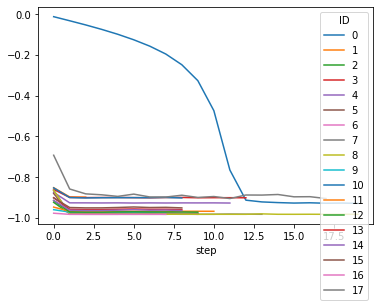

In [6]:
#Extract data from mlruns and visualize data
client = mlflow.tracking.MlflowClient()
metricKey = 'loss'
history_complete = pd.DataFrame
id = 0
backbone_dir = r"mlruns/" + str(EXP1.experiment_id) + "/"
#print(backbone_dir)

#show loss compared to steps per epochs from backbone training
for file in os.listdir(backbone_dir):
    new_path = backbone_dir + file + "/"
    #print(file)
    if (os.path.isdir(new_path)) and ('metrics' in os.listdir(new_path)):
        runID = file
        history = client.get_metric_history(runID, metricKey)
        history = [dict(ID = id, key=m.key, value=m.value, timestamp=m.timestamp, step=m.step) for m in history]
        history = pd.DataFrame(history).sort_values("step")
        history.timestamp = pd.to_datetime(history.timestamp, unit="ms")
        if history_complete.empty:
            history_complete = history
        else:
            history_complete = pd.concat((history_complete, history))
        #print(history_complete)
        id += 1
history_complete.pivot(index="step", columns="ID", values="value").plot()


['only cropped' 'additional cropped - RandAugment' 'additional cropped'
 'additional all - RandAugment']
['ResNet only' 'RandAug, 2500' 'normal DA, 20000' 'RandAug, 20000'
 'normal DA, 2500']


<AxesSubplot:xlabel='mode', ylabel='test_acc'>

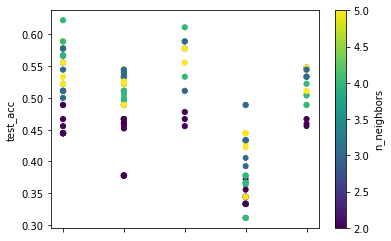

In [7]:
#visualize finetuning results based on neighbours, mode and test accuracy
finetune_dir = r"mlruns/" + str(EXP2.experiment_id) + "/"
history_complete = pd.DataFrame
client = mlflow.tracking.MlflowClient()
for file in os.listdir(finetune_dir):
    new_path = finetune_dir + file + "/"
    if (os.path.isdir(new_path)) and ('params' in os.listdir(new_path)):
        param_path = new_path+ 'params/'
        parameter = []
        values = []
        if 'BACKBONE_ID' in os.listdir(param_path):
            for params in os.listdir(param_path):
                final_path = param_path + params
                parameter.append(params)
                with open(final_path) as f:
                    param = f.readlines()
                    try:
                        values.append(float(param[0]))
                    except:
                        values.append(param[0])
            DictParams = dict(zip(parameter, values))
            history = pd.DataFrame(DictParams, index=[0])
            if history_complete.empty:
                history_complete = history
            else:
                history_complete = pd.concat((history_complete, history))
#history_complete['mode'] = history_complete["mode"].astype('category')
print(history_complete["mode"].unique())
#history_complete["mode"] = history_complete["mode"].cat.codes
history_complete.loc[history_complete['mode'] == 'only cropped', 'mode'] = 'normal DA, 2500'
history_complete.loc[history_complete['mode'] == 'additional cropped',
                     'mode'] = 'normal DA, 20000'
history_complete.loc[history_complete['mode'] == 'additional cropped - RandAugment',
                     'mode'] = 'RandAug, 2500'
history_complete.loc[history_complete['mode'] == 'additional all - RandAugment',
                     'mode'] = 'RandAug, 20000'
history_complete.loc[history_complete.BACKBONE_ID == 'onlyResNet', 'mode'] = 'ResNet only'
print(history_complete["mode"].unique())
history_complete["TRAIN_TEST_SPLIT"] = history_complete["TRAIN_TEST_SPLIT"]*30
#history_complete =  history_complete[history_complete.n_neighbors > 3]
#history_complete = history_complete[history_complete.n_neighbors < 5]
history_complete = history_complete[history_complete.TRAIN_TEST_SPLIT > 0.5*30]
history_complete.plot.scatter(c="n_neighbors",
                                                                               y="test_acc",
                                                                               s="TRAIN_TEST_SPLIT",
                                                                               x="mode",
                                                                               colormap='viridis')


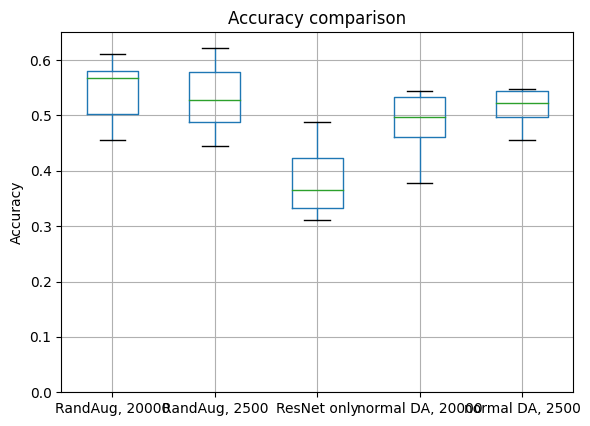

<Figure size 640x480 with 0 Axes>

In [8]:
#compare accuracy between different modes
#plt.style.use('dark_background')
plt.style.use('default')
#history_complete.loc[history_complete['mode'] < 4, 'mode'] = 'with self-supervised finetuning'
#history_complete.loc[history_complete['mode'] == 4, 'mode'] = 'only ResNet'
history_complete.boxplot(
    column=['test_acc'],
    by=['mode'])
plt.title('Accuracy comparison')
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Accuracy')
plt.ylim(0,0.65)
plt.show()
plt.savefig('accuracy_comparison.png')


                mode  n_neighbors  TRAIN_TEST_SPLIT  \
0     RandAug, 20000          2.0              27.0   
1     RandAug, 20000          3.0              27.0   
2     RandAug, 20000          4.0              27.0   
3     RandAug, 20000          5.0              27.0   
4      RandAug, 2500          2.0              27.0   
5      RandAug, 2500          3.0              27.0   
6      RandAug, 2500          4.0              27.0   
7      RandAug, 2500          5.0              27.0   
8        ResNet only          2.0              28.5   
9        ResNet only          3.0              28.5   
10       ResNet only          4.0              28.5   
11       ResNet only          5.0              28.5   
12  normal DA, 20000          2.0              28.5   
13  normal DA, 20000          3.0              28.5   
14  normal DA, 20000          4.0              28.5   
15  normal DA, 20000          5.0              28.5   
16   normal DA, 2500          2.0              27.0   
17   norma

/var/folders/9h/259zfmt527q30fd6b217g0fh0000gn/T/ipykernel_37612/23870088.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  history_plot = history_complete.groupby(['mode', 'n_neighbors']).max().reset_index()


<AxesSubplot:xlabel='n_neighbors'>

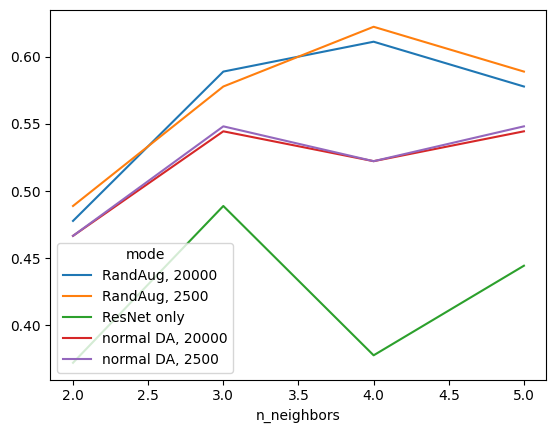

In [9]:
#compare accuracy, mode and neighbours
history_plot = history_complete.groupby(['mode', 'n_neighbors']).max().reset_index()
print(history_plot)
history_plot.pivot(index="n_neighbors", columns="mode", values="test_acc").plot()